### Challenge
At FakeFashionCorp, we're always looking to **improve our product recommendations for our customers**. As a member of our data science team, your task is to make the best recommendations possible based on the provided data:

- **Customer Search Data**: A list of google search queries made by a **specific** customer. You can find the data in the `./search_history.json` file.
- **Product Catalog**: A dataset containing 100,000 **fashion items** from our current inventory, including details such as product name, category, description, and other relevant attributes. You can find the data in the `./fashion_catalog.json` file.

Your challenge is to analyze the customer's search history and use this information to select the most relevant items from our product catalog that we should recommend to this customer.

Here are the specific requirements:

- Select the top items that best match the customer's apparent interests and preferences.
- Provide a brief explanation of your approach, including any assumptions you made and the reasoning behind your methodology.
- Include any visualizations or metrics that support your recommendations.
- Make sure to include the cell output in the final commit, we will **not** execute the script ourselves.

### Dummy approach
The following is what we consider a **dummy** approach. We expect you to find a more clever solution that this:
1. embed the customer's searches
2. rank the searches according to some semantic similarity to a fashion related anchor
3. for each fashion related search, find the product in the catalog that is most similar

We encourage you to be creative in your approach. There's no single correct solution, and we're interested in seeing how you tackle this real-world problem.

Hint: **how can we truly understand the customer's preferences?**

# starts here

To build a smarter and more accurate product recommendation system, I experimented with combining several targeted techniques. Here’s the core idea broken down into four parts:

**Time-Decay Weighting**
The idea is that a user’s recent searches should carry more weight. So, I applied an exponential decay function to prioritize newer searches. This allows the system to dynamically adjust based on the user’s current interests, rather than being overly influenced by older searches.

**Knowledge Graph Construction**
I extracted entities like brands, categories, and styles from the user’s search history and product descriptions, then connected them into a network. For example, a search term might be linked to a product category, and that category might be associated with specific brands. This helps the system better understand the intent behind the user’s searches, moving beyond simple keyword matching.

**Semantic Similarity Matching**
For the recommendation process, I used BERT embeddings combined with cosine similarity to measure the semantic relationship between user searches and product descriptions. For instance, if a user searches for “elegant summer dresses,” BERT can recognize its semantic similarity to “chic summer outfits,” ensuring relevant products are not missed due to differing keywords.

**Personalized Recommendation Optimization**
This part brings everything together by combining the knowledge graph and time-decay weights. In essence, the system not only considers the user’s long-term preferences but also quickly adapts to their short-term interests. The final recommendations strike a balance between familiar categories and new possibilities.

Overall, the goal is to make the recommendations more tailored to the user’s real needs, moving beyond static rules or simple similarity matching.

**Notes and Limitations:**
Considering the direction of this project, I have experimented with integrating a knowledge graph. My understanding of this approach is still at a beginner level, and I plan to deepen my knowledge in this area over time.

To ensure the project runs smoothly and efficiently, I have limited the embedding process to a sample size of 100. While this may constrain the scope, I believe it sufficiently demonstrates my overall approach and thought process.

Currently, the knowledge graph includes numerous time-related nodes, which I believe is due to insufficient data cleaning. This issue could be resolved in the future when more time is available to refine the data preprocessing step.

In [47]:
!pip install transformers
import json
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModel
import torch
import os
from concurrent.futures import ThreadPoolExecutor
# load data
with open('search_history.json', 'r', encoding='utf-8') as f:
    raw_search_history = json.load(f)

with open('fashion_catalog.json', 'r', encoding='utf-8') as f:
    fashion_catalog = json.load(f)

# Load a smaller, faster BERT model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")  # Faster BERT
model = AutoModel.from_pretrained("distilbert-base-uncased")

# Function to get BERT embeddings
def get_embedding(text):
    if not text:
        return np.zeros((768,))
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128, padding="max_length")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()


In [48]:
#clean search_history data date part
def clean_search_history(raw_data):
    cleaned_data = []

    for entry in raw_data:
        # Extract relevant fields
        title = entry.get('title', '').strip()
        time_raw = entry.get('time', '')

        # Parse and format time as YYYY-MM-DD
        try:
            time_parsed = pd.to_datetime(time_raw)  # Convert to datetime object
            time_formatted = time_parsed.date().isoformat()  # Extract date as string
        except Exception as e:
            print(f"Error parsing time: {time_raw}, skipping entry. Error: {e}")
            continue

        # Skip entries with missing or irrelevant fields
        if not title or not time_formatted:
            continue

        # Add cleaned entry
        cleaned_data.append({
            'title': title,
            'time': time_formatted
        })

    return cleaned_data

# Clean and save the data directly to `search_history`
search_history = clean_search_history(raw_search_history)

NER identifies key information in user search interests and product descriptions.

→Extract entities of user interest from search_history

→Extract product-related entities from fashion_catalog.

In [27]:
import spacy

nlp = spacy.load("en_core_web_sm")

# Extract entities from user searches
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# i.e.
for item in search_history:
    entities = extract_entities(item.get('title', ''))
    print(f"Search Query: {item['title']}, Extracted Entities: {entities}")

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


流式输出内容被截断，只能显示最后 5000 行内容。
Search Query: Searched for rent household items london, Extracted Entities: [('london', 'GPE')]
Search Query: Visited https://www.hss.com/hire/, Extracted Entities: []
Search Query: Searched for rent tools, Extracted Entities: []
Search Query: Searched for rent commerce, Extracted Entities: []
Search Query: Visited https://www.referralcandy.com/blog/ecommerce-business-ideas/, Extracted Entities: []
Search Query: Searched for ecommerce premium service ideas, Extracted Entities: []
Search Query: Visited The 10 Best Online Business Ideas for 2024 - Fit Small Business, Extracted Entities: [('10', 'CARDINAL'), ('Best Online Business Ideas', 'ORG'), ('2024', 'DATE')]
Search Query: Visited Content Ideas For An Ecommerce Site - Search Engine Land, Extracted Entities: []
Search Query: Visited http://startupwhale.com/ecommerce/ecommerce-business-ideas/, Extracted Entities: []
Search Query: Visited https://shopygen.com/ecommerce-business-ideas-2017/, Extracted Entities:

Use an exponential decay function (e.g., exp(-lambda * time gap)) to calculate weights:

lambda controls the decay rate—the larger the value, the less influence older searches have.
weight = exp(-lambda * days_since_search)

In [29]:
import pandas as pd
import networkx as nx
from collections import defaultdict

# Calculate time decay weight (recent searches have a greater impact)
def compute_time_weights(search_history, decay_factor=0.1):
    # Extract timestamps and convert to datetime, handling parsing errors
    timestamps = [item['time'] for item in search_history]
    dates = pd.to_datetime(timestamps, errors='coerce', utc=True).date  # Convert to simple date format

    # Filter out invalid dates (NaT)
    dates = [date for date in dates if pd.notnull(date)]

    # Get the current date
    today = pd.to_datetime("today").date()

    # Calculate time weights
    time_weights = {}
    for date in dates:
        days_since_search = (today - date).days
        weight = np.exp(-decay_factor * days_since_search)  # Exponential decay calculation
        time_weights[date] = time_weights.get(date, 0) + weight  # Accumulate weights by date

    return time_weights


The knowledge graph connects different entities, enhancing the semantic understanding of recommendations. It assists the recommendation process by leveraging entity relationships. If a user searches for an entity that exists in the knowledge graph, the system can query its **related_to relationships** to find relevant categories and recommend products within those categories. If the entity itself is not a category but has a **describes relationship** with one, the recommendation scope can be expanded. Similarly, if the searched entity is a brand that has a **sold_by relationship** in the knowledge graph, the system can recommend popular products from that brand.

By establishing connections between NER-extracted entities and product categories, the knowledge graph enables semantic expansion, allowing the recommendation system to identify broader relevant categories. For example, a search for "summer" can be linked to related categories like dress and shoes, improving recommendation diversity.

When integrated with the recommendation system, the knowledge graph enables smarter and more context-aware recommendations. For instance, if a user searches for "elegant summer dress", NER extracts key entities: elegant, summer, dress. The knowledge graph then identifies summer as related to dress and elegant as linked to formal wear, leading to a final recommendation that includes products from both dress and formal wear categories, rather than limiting results to just dress.

In [57]:
# Add time nodes (e.g., 2025-02-09) to the knowledge graph and use time weights as edge weights:
def auto_build_knowledge_graph_with_time(search_history, fashion_catalog, decay_factor=0.1):
    kg = nx.Graph()
    entity_category_map = defaultdict(set)
    time_weights = compute_time_weights(search_history, decay_factor)  # Compute time weights

    # Add user search entities with time weights
    for search in search_history:
        search_time = pd.to_datetime(search['time']).date  # Parse search time
        weight = time_weights.get(search_time, 1.0)  # Retrieve time weight
        kg.add_node(str(search_time), type="time")  # Add time as a node

        entities = extract_entities(search.get('title', ''))  # Extract search entities
        for entity, label in entities:
            kg.add_node(entity, type=label.lower())  # Add entity node
            kg.add_edge(entity, str(search_time), relation="searched_on", weight=weight)  # Connect time to search entity

            # Link to product categories
            for product in fashion_catalog:
                category = product.get('CATEGORY', '').lower()
                if category and entity.lower() in product.get('LONG_DESCRIPTION', '').lower():
                    kg.add_node(category, type="category")
                    kg.add_edge(entity, category, relation="related_to", weight=weight)  # Time impacts category weight

    # Add product descriptions, brands, and categories
    for product in fashion_catalog:
        category = product.get('CATEGORY', '').lower()
        description = product.get('SHORT_DESCRIPTION', '').lower()
        long_description = product.get('LONG_DESCRIPTION', '').lower()
        brand = product.get('LYST_PRODUCT_URL', '').split('/')[-2]  # Assume the second-to-last part of the URL is the brand

        if category:
            kg.add_node(category, type="category")

        # Extract entities from product descriptions
        desc_entities = extract_entities(long_description)
        for entity, label in desc_entities:
            kg.add_node(entity, type=label.lower())
            kg.add_edge(category, entity, relation="describes")

        if brand:
            kg.add_node(brand, type="brand")
            kg.add_edge(category, brand, relation="sold_by")

    return kg


## Optimizing Recommendations with Time Weights
When a user searches for "summer dress", the system first locates the time nodes connected to "summer dress" in the knowledge graph (KG) and retrieves the most recent searches. Using the related_to relationship, it identifies the category dress, but instead of considering all products equally, it ranks them based on time weights. This ensures that products from recently searched categories are prioritized in the recommendations rather than displaying all available items.

This approach deeply integrates knowledge graphs and time analysis. The searched_on relationship in the KG directly stores timestamp information, and the edge weight dynamically adjusts the influence of past searches—more recent searches carry greater weight in shaping recommendations. This results in a dynamically adaptive recommendation system, where recent user activity significantly impacts the ranking, ensuring that products of genuine interest appear at the top.

By combining NER (Named Entity Recognition), knowledge graphs, and time-based weighting, the system delivers smarter and behavior-driven recommendations, aligning more accurately with real user preferences.

In [31]:
def recommend_products_with_kg(search_history, fashion_catalog, kg, time_sensitive=False):
    recommendations = []

    for search in search_history:
        entities = extract_entities(search.get('title', ''))  # Extract search entities
        for entity, label in entities:
            if entity in kg.nodes:
                related_categories = []

                # Retrieve related categories from the knowledge graph
                for neighbor in kg.neighbors(entity):
                    if kg.nodes[neighbor].get("type") == "category":
                        weight = kg[entity][neighbor].get("weight", 1.0) if time_sensitive else 1.0
                        related_categories.append((neighbor, weight))

                # Sort by weight if time-sensitive
                related_categories.sort(key=lambda x: x[1], reverse=True)

                # Recommend products based on categories
                for category, weight in related_categories:
                    for product in fashion_catalog:
                        if product.get('CATEGORY', '').lower() == category.lower():
                            recommendations.append((product, weight))

    # Sort and return only products
    recommendations.sort(key=lambda x: x[1], reverse=True)
    return [rec[0] for rec in recommendations]


Graph too large for visualization. Sampling 100 nodes.


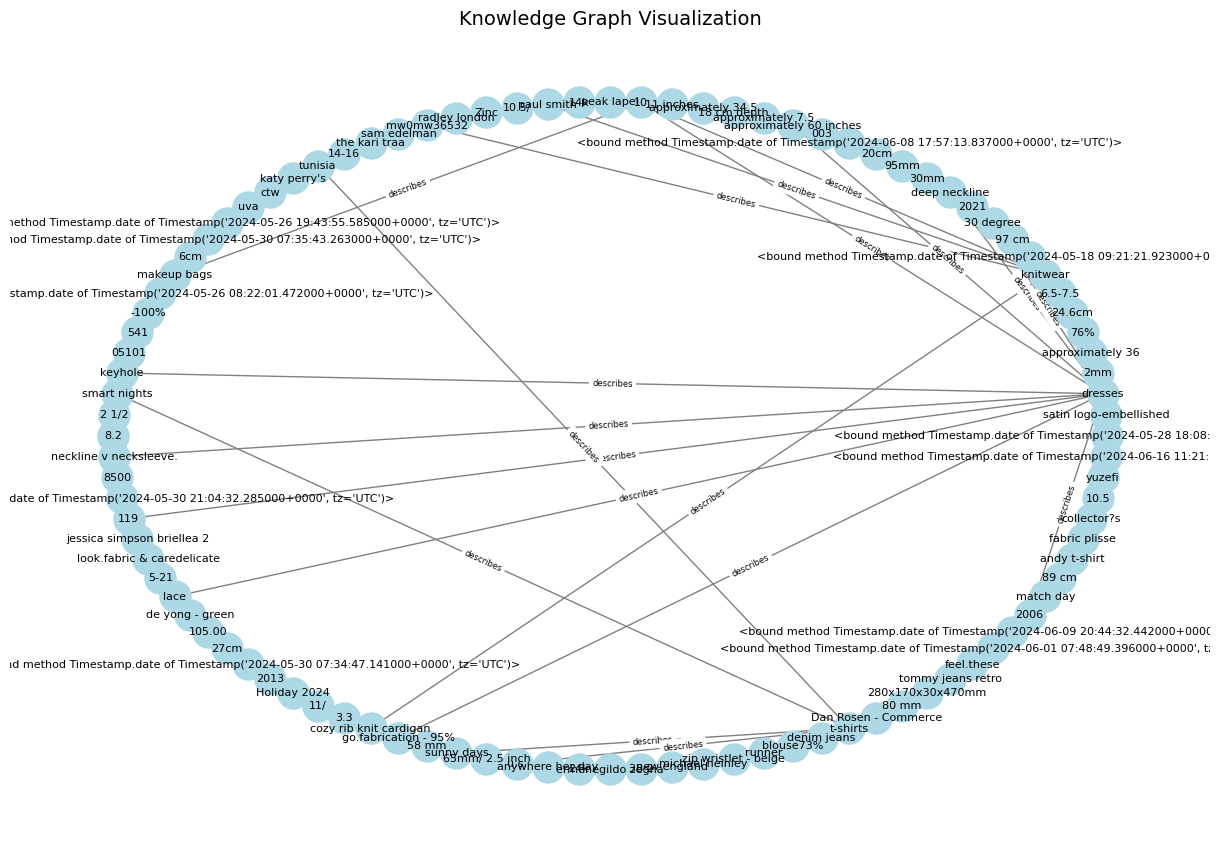

In [58]:
import matplotlib.pyplot as plt
import random
def visualize_knowledge_graph(kg, max_nodes=100, relation_filter=None, layout="shell"):
    plt.figure(figsize=(12, 8))

    # Step 1: Limit the number of nodes
    if len(kg.nodes) > max_nodes:
        print(f"Graph too large for visualization. Sampling {max_nodes} nodes.")
        sampled_nodes = random.sample(list(kg.nodes), max_nodes)
        subgraph = kg.subgraph(sampled_nodes)
    else:
        subgraph = kg

    # Step 2: Filter by edge relationship type (optional)
    if relation_filter:
        subgraph = nx.Graph(
            (u, v, d) for u, v, d in subgraph.edges(data=True) if d.get("relation") == relation_filter
        )
        print(f"Filtered subgraph to show only '{relation_filter}' relations.")

    # Step 3: Handle empty subgraphs
    if len(subgraph.nodes) == 0:
        print("No nodes in the subgraph to visualize. Please check the filters or data.")
        return
    if len(subgraph.edges) == 0:
        print("No edges in the subgraph to visualize. Please check the filters or data.")
        return

    # Step 4: Choose a robust layout algorithm
    if layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(subgraph)  # Better for sparse graphs
    else:
        pos = nx.shell_layout(subgraph)  # Default layout for clarity

    # Step 5: Draw the graph
    nx.draw(
        subgraph, pos, with_labels=True,
        node_size=500, node_color="lightblue", font_size=8, edge_color="gray"
    )
    edge_labels = nx.get_edge_attributes(subgraph, 'relation')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=6)

    plt.title("Knowledge Graph Visualization", fontsize=14)
    plt.show()
visualize_knowledge_graph(kg)


In [ ]:
def visualize_knowledge_graph(kg, relation_filter=None, layout="spring"):
    plt.figure(figsize=(12, 8))

    # Step 1: Handle edge filtering
    if relation_filter:
        subgraph = nx.Graph(
            (u, v, d) for u, v, d in kg.edges(data=True) if d.get("relation") == relation_filter
        )
        print(f"Filtered graph to show only '{relation_filter}' relations.")
    else:
        subgraph = kg

    # Step 2: Handle empty graphs
    if len(subgraph.nodes) == 0:
        print("No nodes in the graph to visualize. Please check the data.")
        return
    if len(subgraph.edges) == 0:
        print("No edges in the graph to visualize. Please check the data.")
        return

    # Step 3: Choose a robust layout algorithm
    pos = nx.spring_layout(subgraph, seed=42, k=0.1)

    # Step 4: Draw the graph
    nx.draw(
        subgraph, pos, with_labels=True,
        node_size=500, node_color="lightblue", font_size=8, edge_color="gray"
    )
    edge_labels = nx.get_edge_attributes(subgraph, 'relation')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=6)

    plt.title("Knowledge Graph Visualization", fontsize=14)
    plt.show()
visualize_knowledge_graph(kg)

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
from concurrent.futures import ThreadPoolExecutor

# Set sample size for testing (only process the first 100 products and 100 search queries)
sample_size = 100
fashion_catalog_sample = fashion_catalog[:sample_size]
search_history_sample = search_history[:100]  # Only process the first 100 search queries

# Cache file for precomputed embeddings
cache_file = "product_embeddings.json"

# Load cached embeddings if available
if os.path.exists(cache_file):
    with open(cache_file, "r", encoding="utf-8") as f:
        product_embeddings = json.load(f)
    print(f" Loaded {len(product_embeddings)} product embeddings from cache.")
else:
    product_embeddings = {}

# Function to process a single product
def process_product(product):
    product_url = product['LYST_PRODUCT_URL']
    if product_url not in product_embeddings:
        product_embeddings[product_url] = get_embedding(product['SHORT_DESCRIPTION']).tolist()
    return product_url, product_embeddings[product_url]

# Compute missing embeddings using multi-threading
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers based on CPU cores
    results = list(executor.map(process_product, fashion_catalog_sample))

# Update product embeddings dictionary
product_embeddings.update(dict(results))

# Save embeddings to cache
with open(cache_file, "w", encoding="utf-8") as f:
    json.dump(product_embeddings, f)

print(f" Computed embeddings for {sample_size} products and saved to cache.")

def recommend_products_with_kg(search_history_sample, fashion_catalog_sample, kg, top_n=5):
    recommendations = []

    for search in search_history_sample:  # Ensure we're using the sampled search history
        search_embedding = get_embedding(search.get('title', ''))  # Compute search query embedding
        entities = extract_entities(search.get('title', ''))  # Extract entities from search query
        related_categories = set()

        # Retrieve categories corresponding to search entities
        for entity, label in entities:
            if entity in kg.nodes:
                neighbors = [
                    neighbor for neighbor in kg.neighbors(entity)
                    if kg.nodes[neighbor].get("type") == "category"
                ]
                related_categories.update(neighbors)

        similarities = []
        for product in fashion_catalog_sample:  # Process only sampled data
            category = product.get('CATEGORY', '').lower()

            # **Only compute BERT similarity for products in relevant categories**
            if related_categories and category not in related_categories:
                continue  # Skip unrelated categories to improve efficiency

            product_url = product['LYST_PRODUCT_URL']
            product_embedding = np.array(product_embeddings[product_url])  # Load from cache

            similarity = cosine_similarity(search_embedding.reshape(1, -1), product_embedding.reshape(1, -1))[0][0]

            # Apply weight for category relevance
            weight = 1.5 if category in related_categories else 1.0
            similarities.append((product, similarity * weight))

        # Sort by similarity
        top_matches = sorted(similarities, key=lambda x: x[1], reverse=True)[:top_n]
        recommendations.extend([match[0] for match in top_matches])

    return recommendations[:top_n]  # Only return top 5 overall

# Execute recommendations using the sampled dataset
recommended_products = recommend_products_with_kg(search_history_sample, fashion_catalog_sample, kg)

# Print recommended products
print("Recommended Products:")
for product in recommended_products:
    print(f"- {product['SHORT_DESCRIPTION']} ({product['LYST_PRODUCT_URL']})")

print(f" Recommendation process completed!")


 Loaded 100 product embeddings from cache.
 Computed embeddings for 100 products and saved to cache.
Recommended Products:
- Light Melange 4G Logo-Appliqué Cotton-Jersey T-Shirt (https://www.lyst.com/clothing/givenchy-4g-logo-applique-cotton-jersey-t-shirt-x-1)
- Nic+zoe Crisp Stretch Wide-leg Pant (https://www.lyst.com/clothing/niczoe-crisp-stretch-wide-leg-pant-1)
- Golf You-v Solid 1/4 Zip (https://www.lyst.com/clothing/puma-golf-you-v-solid-14-zip-1)
- Kaiia Studio Bubble Logo Zip Up Hoodie Grey Marl & Red (https://www.lyst.com/clothing/public-desire-kaiia-studio-bubble-logo-zip-up-hoodie-grey-marl-red)
- Frill Ruffle Bardot Mini Dress (https://www.lyst.com/clothing/topshop-frill-ruffle-bardot-mini-dress-2)
 Recommendation process completed!


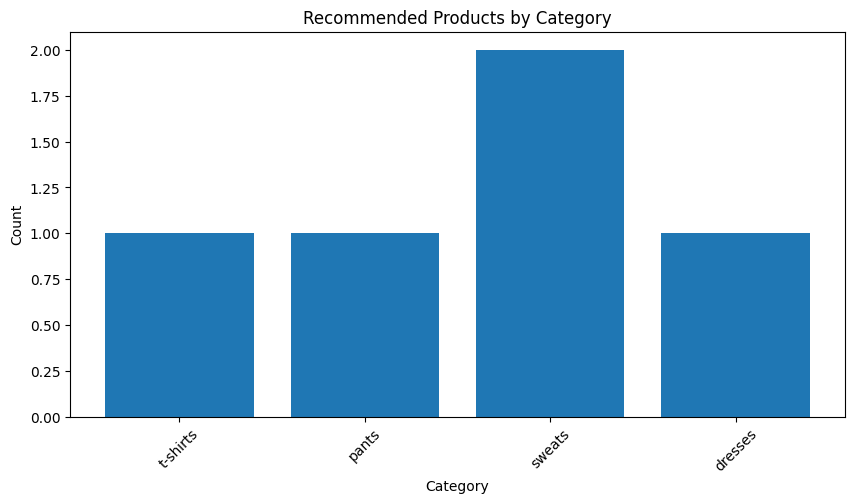

In [34]:
#Visualize recommendation results
from collections import Counter # Import Counter from collections

def plot_recommendations(recommendations):
    categories = [rec['CATEGORY'] for rec in recommendations]
    category_counts = Counter(categories)

    plt.figure(figsize=(10, 5))
    plt.bar(category_counts.keys(), category_counts.values())
    plt.title("Recommended Products by Category")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()
plot_recommendations(recommended_products)

Calculating time weights...
Building the knowledge graph...
Generating recommendations...
Visualizing recommended product categories...


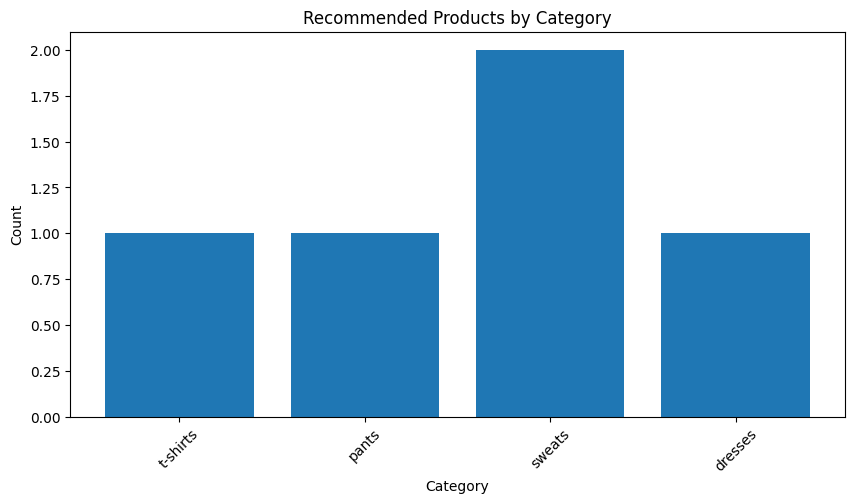


Recommended Products:
- Light Melange 4G Logo-Appliqué Cotton-Jersey T-Shirt (https://www.lyst.com/clothing/givenchy-4g-logo-applique-cotton-jersey-t-shirt-x-1)
- Nic+zoe Crisp Stretch Wide-leg Pant (https://www.lyst.com/clothing/niczoe-crisp-stretch-wide-leg-pant-1)
- Golf You-v Solid 1/4 Zip (https://www.lyst.com/clothing/puma-golf-you-v-solid-14-zip-1)
- Kaiia Studio Bubble Logo Zip Up Hoodie Grey Marl & Red (https://www.lyst.com/clothing/public-desire-kaiia-studio-bubble-logo-zip-up-hoodie-grey-marl-red)
- Frill Ruffle Bardot Mini Dress (https://www.lyst.com/clothing/topshop-frill-ruffle-bardot-mini-dress-2)


In [35]:
# Directly Execute Recommendation
def get_final_recommendations(search_history, fashion_catalog, visualize=True):
    """
    Call this function directly to obtain the final recommendation results.
    """
    print("Calculating time weights...")
    time_weights = compute_time_weights(search_history)

    print("Building the knowledge graph...")
    # Use auto_build_knowledge_graph_with_time instead of build_knowledge_graph
    kg = auto_build_knowledge_graph_with_time(search_history_sample, fashion_catalog_sample)

    print("Generating recommendations...")
    # Assuming recommend_products should be recommend_products_with_kg
    recommendations = recommend_products_with_kg(search_history_sample, fashion_catalog_sample, kg)

    if visualize:
        print("Visualizing recommended product categories...")
        plot_recommendations(recommendations)

    print("\nRecommended Products:")
    for rec in recommendations:
        print(f"- {rec['SHORT_DESCRIPTION']} ({rec['LYST_PRODUCT_URL']})")

    return recommendations

# **Call the final recommendation function**
recommended_products = get_final_recommendations(search_history_sample, fashion_catalog_sample)